In [22]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, sobel, convolve
import matplotlib.pyplot as plt
import os

def HarrisPointsDetector(image, sigma=0.5, threshold=0.08):
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray_img = np.float32(gray_img)

  # Calculate gradients at each direction
  Ix = sobel(gray_img, axis=1, mode='reflect')
  Iy = sobel(gray_img, axis=0, mode='reflect')

  gaussian_filter = cv2.getGaussianKernel(ksize=5, sigma=sigma)
  gaussian_filter = np.outer(gaussian_filter, gaussian_filter)

  # Calculate Ixx, Iyy and Ix*Iy for computing the Harris matrix
  Ixx = convolve(Ix**2, gaussian_filter, mode='reflect')
  Ixy = convolve(Ix*Iy, gaussian_filter, mode='reflect')
  Iyy = convolve(Iy**2, gaussian_filter, mode='reflect')

  detM = Ixx * Iyy - Ixy**2
  traceM = Ixx + Iyy
  R = detM - 0.05 * (traceM**2)
  
  local_max = (R == maximum_filter(R, size=(7, 7), mode='reflect'))
  threshold = threshold * R.max()
  keypoints = np.argwhere((R > threshold) & local_max)

  # Orientation
  orientation = np.arctan2(Iy, Ix)
  orientation = np.degrees(orientation)

  keypoints_with_orientation = [cv2.KeyPoint(float(x[1]), float(x[0]), size=20, angle=float(orientation[x[0], x[1]])) for x in keypoints]

  return keypoints_with_orientation

def featureDescriptor(image, keypoints):
  orb = cv2.ORB_create()

  keypoints, descriptors = orb.compute(image, keypoints)

  return descriptors

In [23]:
# ref_img_path = 'drive/MyDrive/cv_cw2/bernieSanders.jpg'
# ref_img = cv2.imread(ref_img_path)

# benchmark_dir = 'drive/MyDrive/cv_cw2/COMP37212'
# benchmark_image_files = [f for f in os.listdir(benchmark_dir) if os.path.isfile(os.path.join(benchmark_dir, f))]

# threshold_values = np.linspace(0.01, 0.1, 50)

# num_images = len(benchmark_image_files) + 1
# num_cols = 2
# num_rows = (num_images + 1) // num_cols

# plt.figure(figsize=(20, 5 * num_rows))

# # Compute keypoint detection for the reference image
# ref_num_keypoints_custom = []

# for threshold in threshold_values:
#     ref_keypoints_custom = HarrisPointsDetector(ref_img, sigma=0.5, threshold=threshold)
#     ref_num_keypoints_custom.append(len(ref_keypoints_custom))

# plt.subplot(num_rows, num_cols, 1)
# plt.plot(threshold_values, ref_num_keypoints_custom, marker='o', label='Custom Harris Detector')
# plt.xlabel('Threshold Value')
# plt.ylabel('Number of Keypoints Detected')
# plt.title('Reference Image')
# plt.legend()
# plt.grid(True)

# # Compute keypoint detection for each benchmark image
# for num_image, benchmark_image_file in enumerate(benchmark_image_files):
#     benchmark_image_path = os.path.join(benchmark_dir, benchmark_image_file)
#     benchmark_img = cv2.imread(benchmark_image_path)

#     benchmark_num_keypoints_custom = []

#     for threshold in threshold_values:
#         benchmark_keypoints_custom = HarrisPointsDetector(benchmark_img, sigma=0.5, threshold=threshold)
#         benchmark_num_keypoints_custom.append(len(benchmark_keypoints_custom))

#     plt.subplot(num_rows, num_cols, num_image + 2)
#     plt.plot(threshold_values, benchmark_num_keypoints_custom, marker='o', label='Custom Harris Detector')
#     plt.xlabel('Threshold Value')
#     plt.ylabel('Number of Keypoints Detected')
#     plt.title(f'Benchmark Image {num_image+1}')
#     plt.legend()
#     plt.grid(True)

# plt.tight_layout()
# plt.show()

In [24]:
# plt.figure(figsize=(20, 5 * num_rows))

# ref_img_path = 'drive/MyDrive/cv_cw2/COMP37212/bernie180.jpg'
# ref_img = cv2.imread(ref_img_path)

# # Compute interest points for the reference image
# ref_keypoints = HarrisPointsDetector(ref_img, threshold=0.045)
# ref_img_with_keypoints = cv2.drawKeypoints(ref_img, ref_keypoints, None, color=(255, 255, 0))
# cv2_imshow(ref_img_with_keypoints)

In [25]:
# ref_img_path = 'drive/MyDrive/cv_cw2/COMP37212/brighterBernie.jpg'
# ref_img = cv2.imread(ref_img_path)

# # Create an instance of ORB detector with FAST keypoints
# orb_fast = cv2.ORB_create()

# # Create another instance of ORB detector with Harris corners
# orb_harris = cv2.ORB_create(scoreType=cv2.ORB_HARRIS_SCORE)

# kp_fast = orb_fast.detect(ref_img, None)
# kp_harris = orb_harris.detect(ref_img, None)

# _, descriptors_FAST = orb_fast.compute(ref_img, kp_fast)
# _, descriptors_Harris = orb_harris.compute(ref_img, kp_harris)

# image_orb_harris = cv2.drawKeypoints(ref_img, kp_harris, None, color=(255, 255, 0))
# image_orb_fast = cv2.drawKeypoints(ref_img, kp_fast, None, color=(255, 255, 0))

# # Convert to RGB for Matplotlib
# image_orb_harris_rgb = cv2.cvtColor(image_orb_harris, cv2.COLOR_BGR2RGB)
# image_orb_fast_rgb = cv2.cvtColor(image_orb_fast, cv2.COLOR_BGR2RGB)

# # Display the images
# plt.figure(figsize=(24, 12))

# plt.subplot(1, 2, 1)
# plt.imshow(image_orb_harris_rgb)
# plt.title(f'ORB Harris (Keypoints: {len(kp_harris)})')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(image_orb_fast_rgb)
# plt.title(f'ORB FAST (Keypoints: {len(kp_fast)})')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [26]:
from scipy.spatial.distance import cdist

def calculate_ssd(des1, des2):
  ssd_matrix = cdist(des1, des2, 'sqeuclidean')  # 'sqeuclidean' computes the squared Euclidean distance
  return ssd_matrix

def ratio_test(ssd_matrix, threshold=0.8):
  matches = []
  for i, ssds in enumerate(ssd_matrix):
    sorted_indices = np.argsort(ssds)
    closest, second_closest = sorted_indices[:2]

    if ssds[closest] / ssds[second_closest] < threshold:
      # Append a cv2.DMatch object to the list of matches
      matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=closest, _distance=ssds[closest]))

  return matches

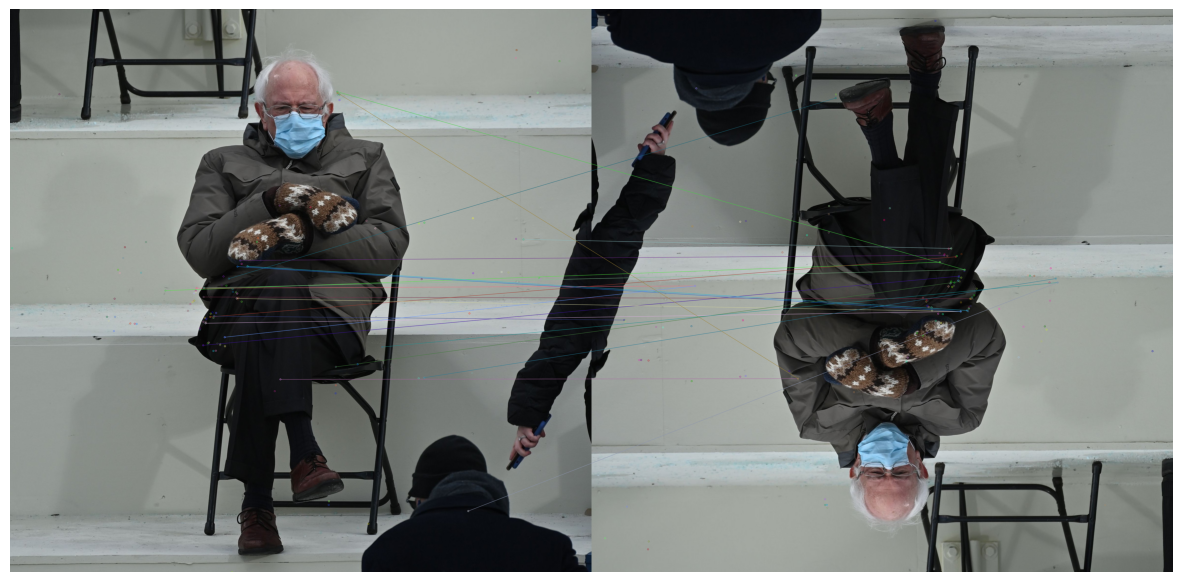

Image: COMP37212/bernie180.jpg
Number of matches: 22


In [27]:
benchmark_image_path = 'COMP37212/bernie180.jpg'
benchmark_img = cv2.imread(benchmark_image_path)

ref_img = cv2.imread('reference_image/bernieSanders.jpg')

kp_ref = HarrisPointsDetector(ref_img)
des_ref = featureDescriptor(ref_img, kp_ref)

kp_benchmark = HarrisPointsDetector(benchmark_img)
des_benchmark = featureDescriptor(benchmark_img, kp_benchmark)

ssd_matrix = calculate_ssd(des_ref, des_benchmark)
matches = ratio_test(ssd_matrix)

matched_img = cv2.drawMatches(ref_img, kp_ref, benchmark_img, kp_benchmark, matches, None)
matched_img_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))  # You can adjust the figure size as needed
plt.imshow(matched_img_rgb)
plt.axis('off')  # Hide the axis
plt.show()

print(f"Image: {benchmark_image_path}")
print(f"Number of matches: {len(matches)}")

In [1]:
orb = cv2.ORB_create()

ref_img = cv2.imread('reference_image/bernieSanders.jpg')

benchmark_image_path = 'COMP37212/bernie180.jpg'
benchmark_img = cv2.imread(benchmark_image_path)

orb_fast = cv2.ORB_create()
kp_fast_ref = orb_fast.detect(ref_img, None)
kp_fast_benchmark = orb_fast.detect(benchmark_img, None)

_, descriptors_FAST_ref_img = orb_fast.compute(ref_img, kp_fast_ref)
_, descriptors_FAST_benchmark_img = orb_fast.compute(benchmark_img, kp_fast_benchmark)


ssd_matrix = calculate_ssd(descriptors_FAST_ref_img, descriptors_FAST_benchmark_img)
matches = ratio_test(ssd_matrix)

matched_img = cv2.drawMatches(ref_img, kp_fast_ref, benchmark_img, kp_fast_benchmark, matches, None)

print(f"Image: {benchmark_image_path}")
print(f"Number of matches: {len(matches)}")

NameError: name 'cv2' is not defined

In [ ]:
orb_harris = cv2.ORB_create(scoreType=cv2.ORB_HARRIS_SCORE)
kp_harris = orb_harris.detect(ref_img, None)

_, descriptors_Harris = orb_harris.compute(ref_img, kp_harris)